# importing necessary library

In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense , LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import datetime


In [2]:
# getting stock price
start_date = datetime.datetime(2020,1,1) # defining start date
end_date = datetime.datetime(2023,10,1) # defining end date
# importing yfinance to get financial date directly from web
import yfinance as yf

# Define the ticker symbol
tickerSymbol = 'TSLA'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tesla_df = tickerData.history(period='1d', start=start_date, end=end_date)

# See your data
print(tesla_df)


                                 Open        High         Low       Close  \
Date                                                                        
2020-01-02 00:00:00-05:00   28.299999   28.713333   28.114000   28.684000   
2020-01-03 00:00:00-05:00   29.366667   30.266666   29.128000   29.534000   
2020-01-06 00:00:00-05:00   29.364668   30.104000   29.333332   30.102667   
2020-01-07 00:00:00-05:00   30.760000   31.441999   30.224001   31.270666   
2020-01-08 00:00:00-05:00   31.580000   33.232666   31.215334   32.809334   
...                               ...         ...         ...         ...   
2023-09-25 00:00:00-04:00  243.380005  247.100006  238.309998  246.990005   
2023-09-26 00:00:00-04:00  242.979996  249.550003  241.660004  244.119995   
2023-09-27 00:00:00-04:00  244.259995  245.330002  234.580002  240.500000   
2023-09-28 00:00:00-04:00  240.020004  247.550003  238.649994  246.380005   
2023-09-29 00:00:00-04:00  250.000000  254.770004  246.350006  250.220001   

In [3]:
tesla_df.head() # checking top 5 entires

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-01-02 00:00:00-05:00,28.299999,28.713333,28.114000,28.684000,142981500,0.0,0.0
2020-01-03 00:00:00-05:00,29.366667,30.266666,29.128000,29.534000,266677500,0.0,0.0
2020-01-06 00:00:00-05:00,29.364668,30.104000,29.333332,30.102667,151995000,0.0,0.0
2020-01-07 00:00:00-05:00,30.760000,31.441999,30.224001,31.270666,268231500,0.0,0.0
2020-01-08 00:00:00-05:00,31.580000,33.232666,31.215334,32.809334,467164500,0.0,0.0


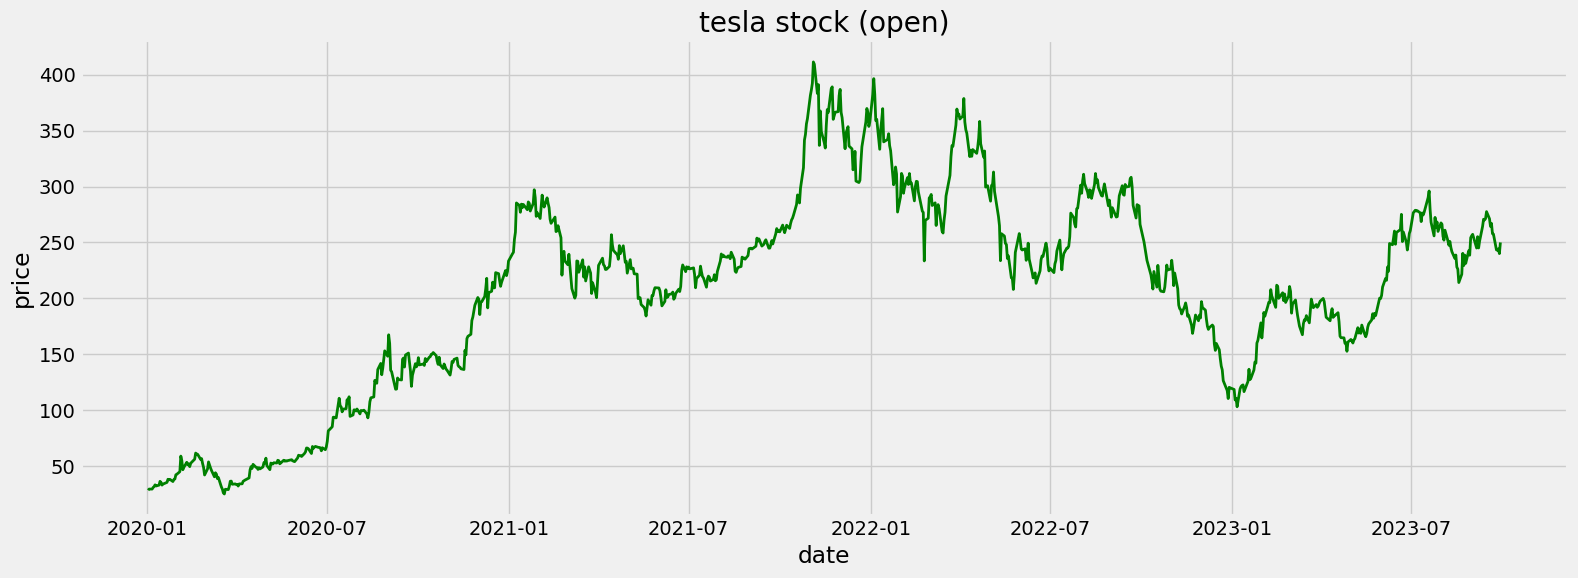

In [4]:
# focusing on open price of tesla stock

data = tesla_df['Open']
plt.figure(figsize=(16,6))
plt.plot(data,color='green',linewidth=2)
plt.title('tesla stock (open)')
plt.xlabel('date')
plt.ylabel('price')
plt.tight_layout()
plt.show()

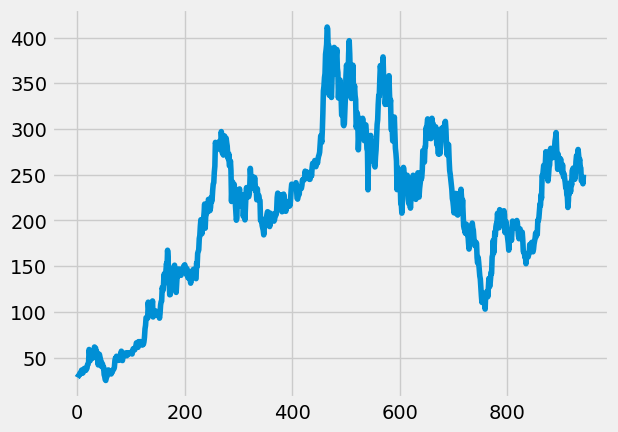

In [5]:
tesla_data = data.values
plt.plot(tesla_data)
# similar to that of data frame

In [6]:
# scaling the data to reduce them to same range between 0 and 1
normalization = MinMaxScaler(feature_range=(0,1))
tesla_scaled =normalization.fit_transform(np.array(tesla_data).reshape(-1,1))
print(tesla_data.shape,tesla_scaled.shape)

(943,) (943, 1)


In [7]:
# now defining data for test and train for model building considering 70% for train and 30% for test
train_size= int(len(tesla_scaled)*.70)
test_size = len(tesla_scaled)-train_size

print(train_size,test_size)

660 283


In [8]:
# assigning train  and test value from scaled data
tesla_train,tesla_test = tesla_scaled[0:train_size,0:1],tesla_scaled[train_size:,0:1]
print(len(tesla_train),len(tesla_test))

660 283


# in this step preparing 3 dim data to fit it on lstm model

In [9]:
def create_data (data_set,time_stamp):
  Xtrain = [] # empty x_train
  Ytrain = [] # empty y_train
  for i in range(time_stamp, len(data_set)):
    Xtrain.append(data_set[i-time_stamp:i, 0])
    Ytrain.append(data_set[i, 0])
  return np.array(Xtrain),np.array(Ytrain)
time_step =60
x_train, y_train = create_data(tesla_train,time_step)


In [10]:
print(f"x train data set dim :{x_train.shape}, y train data set dim :{y_train.shape}")


x train data set dim :(600, 60), y train data set dim :(600,)


In [11]:
def create_data (data_set,time_stamp):
  Xtest = [] # empty x_train
  Ytest = [] # empty y_train
  for i in range(time_stamp, len(data_set)):
    Xtest.append(data_set[i-time_stamp:i, 0])
    Ytest.append(data_set[i, 0])
  return np.array(Xtest),np.array(Ytest)
time_step =60
x_test, y_test = create_data(tesla_test,time_step)

In [12]:
print(f"x test data set dim :{x_test.shape}, y test data set dim :{y_test.shape}")

x test data set dim :(223, 60), y test data set dim :(223,)


In [13]:
# Reshaping the input
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
print(x_test.shape)
print(y_test.shape)
print(x_train.shape)
print(y_train.shape)

(223, 60, 1)
(223,)
(600, 60, 1)
(600,)


In [14]:
# model building
model = Sequential() # initiating sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1],1))) # assinging 50 memory cell
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#initilazing model with optimmizer adam taking mean square loss and metric is mean absolute error
model.compile(optimizer = 'adam', loss = 'mse' , metrics="mean_absolute_error")
# Fitting the LSTM to the Training set
from keras.callbacks import EarlyStopping
# setting call back to control model complexity and avoid overfitting of model
callbacks = [EarlyStopping(monitor='loss', patience=10 , restore_best_weights=True)]
# fitting model
history = model.fit(x_train, y_train, epochs = 100, batch_size = 32 , callbacks = callbacks )

Epoch 1/100
19/19 [==============================] - 11s 143ms/step - loss: 0.0557 - mean_absolute_error: 0.1715
Epoch 2/100
19/19 [==============================] - 2s 97ms/step - loss: 0.0100 - mean_absolute_error: 0.0802
Epoch 3/100
19/19 [==============================] - 2s 98ms/step - loss: 0.0060 - mean_absolute_error: 0.0599
Epoch 4/100
19/19 [==============================] - 2s 95ms/step - loss: 0.0048 - mean_absolute_error: 0.0505
Epoch 5/100
19/19 [==============================] - 2s 98ms/step - loss: 0.0044 - mean_absolute_error: 0.0468
Epoch 6/100
19/19 [==============================] - 2s 106ms/step - loss: 0.0048 - mean_absolute_error: 0.0492
Epoch 7/100
19/19 [==============================] - 3s 164ms/step - loss: 0.0042 - mean_absolute_error: 0.0467
Epoch 8/100
19/19 [==============================] - 3s 136ms/step - loss: 0.0040 - mean_absolute_error: 0.0449
Epoch 9/100
19/19 [==============================] - 2s 98ms/step - loss: 0.0035 - mean_absolute_error: 0.0

# plotting loss as we can see as epoch increases mean absolute error keep on reducing

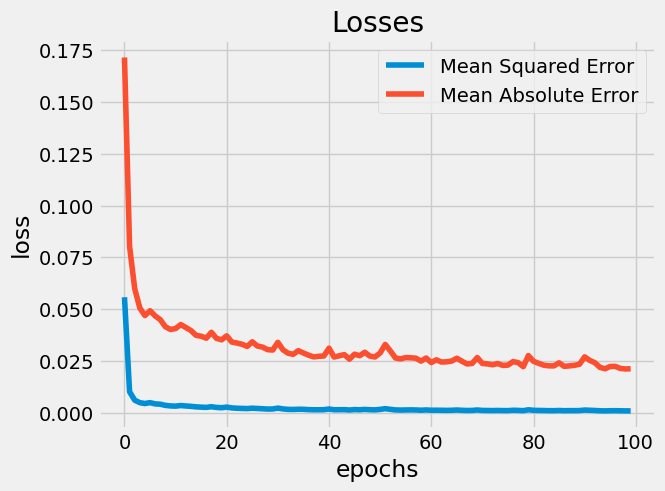

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
#inverse y_test scaling
predictions = model.predict(x_test)

#inverse predictions scaling to return predicted value back to its original form
predictions = normalization.inverse_transform(predictions)
print(predictions.shape)
print(f'predicted values: {predictions} ')



7/7 [==============================] - 2s 33ms/step
(223, 1)
predicted values: [[207.1512  ]
 [199.40715 ]
 [195.82706 ]
 [193.02571 ]
 [194.5659  ]
 [197.8021  ]
 [197.98674 ]
 [193.91336 ]
 [191.03175 ]
 [185.88727 ]
 [179.41168 ]
 [177.28906 ]
 [181.70653 ]
 [184.1614  ]
 [186.90382 ]
 [187.64067 ]
 [193.46555 ]
 [196.29102 ]
 [195.85214 ]
 [191.23926 ]
 [184.99701 ]
 [179.98524 ]
 [178.11601 ]
 [178.77182 ]
 [179.38625 ]
 [173.75389 ]
 [166.49715 ]
 [163.90625 ]
 [161.71718 ]
 [157.64062 ]
 [152.25201 ]
 [147.3201  ]
 [141.36516 ]
 [134.51677 ]
 [127.64537 ]
 [125.16791 ]
 [124.840355]
 [124.87154 ]
 [122.68026 ]
 [120.34658 ]
 [116.925385]
 [117.29044 ]
 [119.80309 ]
 [122.71303 ]
 [125.02328 ]
 [124.96948 ]
 [125.99721 ]
 [130.06447 ]
 [132.10086 ]
 [132.8038  ]
 [134.68715 ]
 [138.59375 ]
 [141.97963 ]
 [149.29337 ]
 [157.09035 ]
 [167.65518 ]
 [171.27597 ]
 [173.97377 ]
 [180.67046 ]
 [185.1863  ]
 [190.67958 ]
 [195.91537 ]
 [198.80104 ]
 [204.94115 ]
 [207.07385 ]
 [203.4526 

In [ ]:
#inverse y_test scaling returning y test to its original value
y_test = normalization.inverse_transform([y_test])
# calculating root mean sq error
RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE

4.26

In [ ]:
print(f'train size:{train_size}')
print('-'*50)
print(f'test size :{test_size}')

train size:660
--------------------------------------------------
test size :283


# plot of predicted value


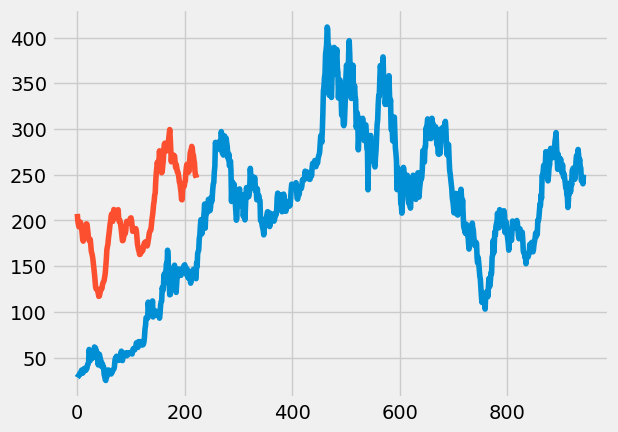

In [ ]:
plt.plot(normalization.inverse_transform(tesla_scaled))
plt.plot(predictions)

In [ ]:
len(tesla_test)

283

# have taken batch size of 60 and trying to predcit next 30 days data

In [ ]:
# considering 60 data
fut_inp = tesla_test[223:]
len(fut_inp)
fut_inp=fut_inp.reshape(1,-1)
temp_inp=list(fut_inp)
fut_inp.shape

(1, 60)

In [ ]:
temp_inp = temp_inp[0].tolist()

# creating window for next 30 day future forecasting

In [ ]:
lst_output =[]
n_steps = 60
i =0
while i<30:
  if(len(temp_inp)>60):
    fut_inp =np.array(temp_inp[1:])
    fut_inp =fut_inp.reshape(1,-1)
    fut_inp =fut_inp.reshape((1,n_steps,1))
    yhat = model.predict(fut_inp,verbose=0)
    temp_inp.extend(yhat[0].tolist())
    temp_inp = temp_inp[1:]
    lst_output.extend(yhat.tolist())
    i+=1
  else:
    fut_inp = fut_inp.reshape((1,n_steps,1))
    yhat = model.predict(fut_inp)
    temp_inp.extend(yhat[0].tolist())
    lst_output.extend(yhat.tolist())
    i+=1

print(lst_output)

1/1 [==============================] - 0s 39ms/step
[[0.5852596759796143], [0.5946030020713806], [0.6029635071754456], [0.6109902858734131], [0.6188060641288757], [0.6265187859535217], [0.6342470645904541], [0.642099916934967], [0.650165319442749], [0.6585060954093933], [0.6671606302261353], [0.6761435270309448], [0.6854496598243713], [0.6950545310974121], [0.7049246430397034], [0.7150141596794128], [0.725270688533783], [0.7356347441673279], [0.7460439205169678], [0.7564327716827393], [0.7667339444160461], [0.7768794298171997], [0.7868047952651978], [0.7964479327201843], [0.805750846862793], [0.8146631717681885], [0.8231419920921326], [0.8311533331871033], [0.8386717438697815], [0.8456825017929077]]


In [ ]:
tesla_scaled.shape

(943, 1)

# plot of future forecasted value

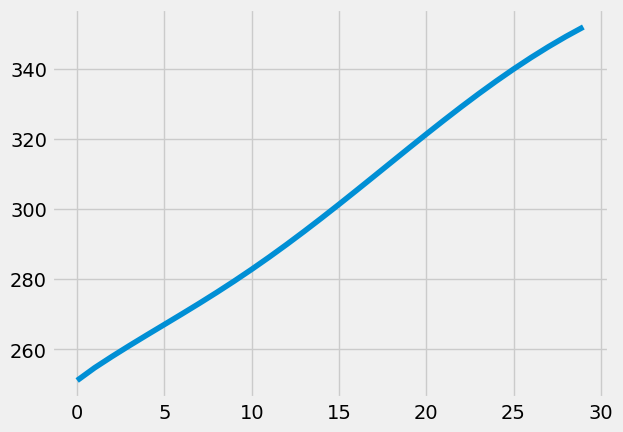

In [ ]:
plt.plot(normalization.inverse_transform(lst_output))

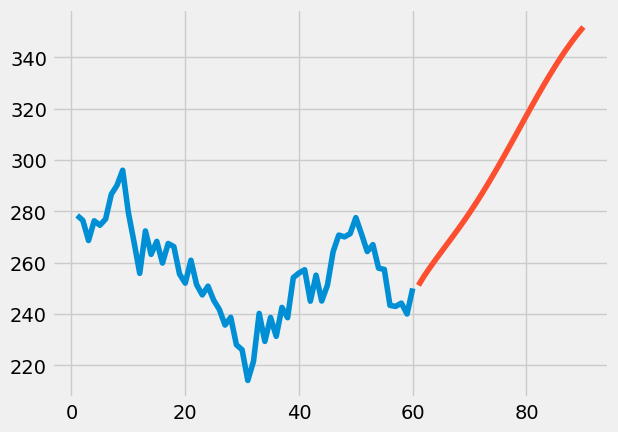

In [ ]:
plot_new =np.arange(1,61)
plot_pred=np.arange(61,91)
plt.plot(plot_new,normalization.inverse_transform(tesla_scaled[883:]))
plt.plot(plot_pred,normalization.inverse_transform(lst_output))


In [ ]:
tesla_new = tesla_scaled.tolist()
len(tesla_new)
tesla_new.extend(lst_output)


In [ ]:
final_graph = normalization.inverse_transform(tesla_new).tolist()

# merged forecasted value to actual data set

Text(0, 0.5, 'price')

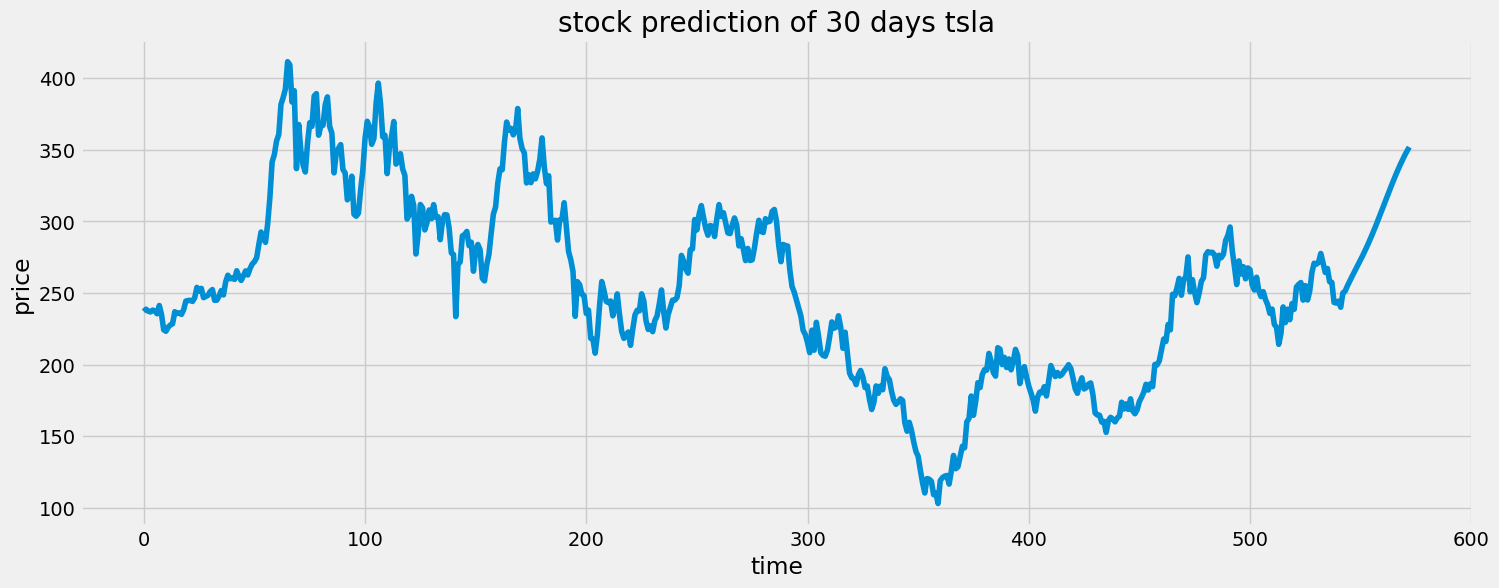

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(final_graph[400:])
plt.title('stock prediction of 30 days tsla')
plt.xlabel('time')
plt.ylabel('price')

# trying to check how close we are in forecasting 30 days data to actual data

In [ ]:
start_date = datetime.datetime(2023,10,1)
end_date = datetime.datetime(2023,11,1)

import yfinance as yf

# Define the ticker symbol
tickerSymbol = 'TSLA'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tesla_df_new = tickerData.history(period='1d', start=start_date, end=end_date)

# See your data
tesla_df_new['Open']


Date
2023-10-02 00:00:00-04:00    244.809998
2023-10-03 00:00:00-04:00    248.610001
2023-10-04 00:00:00-04:00    248.139999
2023-10-05 00:00:00-04:00    260.000000
2023-10-06 00:00:00-04:00    253.979996
2023-10-09 00:00:00-04:00    255.309998
2023-10-10 00:00:00-04:00    257.750000
2023-10-11 00:00:00-04:00    266.200012
2023-10-12 00:00:00-04:00    262.920013
2023-10-13 00:00:00-04:00    258.899994
2023-10-16 00:00:00-04:00    250.050003
2023-10-17 00:00:00-04:00    250.100006
2023-10-18 00:00:00-04:00    252.699997
2023-10-19 00:00:00-04:00    225.949997
2023-10-20 00:00:00-04:00    217.009995
2023-10-23 00:00:00-04:00    210.000000
2023-10-24 00:00:00-04:00    216.500000
2023-10-25 00:00:00-04:00    215.880005
2023-10-26 00:00:00-04:00    211.320007
2023-10-27 00:00:00-04:00    210.600006
2023-10-30 00:00:00-04:00    209.279999
2023-10-31 00:00:00-04:00    196.119995
Name: Open, dtype: float64

In [ ]:
print(final_graph)

[[28.299999237060547], [29.366666793823242], [29.364667892456055], [30.760000228881836], [31.579999923706055], [33.13999938964844], [32.11933135986328], [32.900001525878906], [36.284000396728516], [35.31733322143555], [32.91666793823242], [33.840667724609375], [35.349998474121094], [38.125999450683594], [37.616668701171875], [38.04199981689453], [36.132667541503906], [37.89933395385742], [38.37933349609375], [42.16133117675781], [42.66666793823242], [44.91266632080078], [58.86399841308594], [54.8839988708496], [46.66133117675781], [48.70333480834961], [53.33333206176758], [51.25266647338867], [51.858001708984375], [49.45600128173829], [52.4813346862793], [56.106666564941406], [61.56666564941406], [60.79666519165039], [60.46533203125], [55.93333435058593], [56.599998474121094], [52.16666793823243], [48.66666793823242], [41.97999954223633], [47.41733169555664], [53.66666793823243], [50.930667877197266], [48.2513313293457], [46.0], [40.35933303833008], [43.96200180053711], [42.68000030517

In [ ]:
actual_df = pd.DataFrame(tesla_df_new['Open']).reset_index()
actual_df['pred_Open']=pred_open.iloc[:,0]
actual_df

,Date,Open,pred_Open
0,2023-10-02 00:00:00-04:00,244.809998,251.177013
1,2023-10-03 00:00:00-04:00,248.610001,254.788115
2,2023-10-04 00:00:00-04:00,248.139999,258.019366
3,2023-10-05 00:00:00-04:00,260.000000,261.121636
4,2023-10-06 00:00:00-04:00,253.979996,264.142356
5,2023-10-09 00:00:00-04:00,255.309998,267.123246
6,2023-10-10 00:00:00-04:00,257.750000,270.110149
7,2023-10-11 00:00:00-04:00,266.200012,273.145198
8,2023-10-12 00:00:00-04:00,262.920013,276.262395
9,2023-10-13 00:00:00-04:00,258.899994,279.486021


# creating data frame which consist of actual value predicted value along with error

In [ ]:
error = pd.DataFrame([actual_df['Open'] - actual_df['pred_Open']])
error=error.T
error
actual_df['Error']=error
actual_df



,Open,pred_Open,Error
Date,,,
2023-10-02 00:00:00-04:00,244.809998,251.177013,-6.367015
2023-10-03 00:00:00-04:00,248.610001,254.788115,-6.178114
2023-10-04 00:00:00-04:00,248.139999,258.019366,-9.879367
2023-10-05 00:00:00-04:00,260.000000,261.121636,-1.121636
2023-10-06 00:00:00-04:00,253.979996,264.142356,-10.162361
2023-10-09 00:00:00-04:00,255.309998,267.123246,-11.813249
2023-10-10 00:00:00-04:00,257.750000,270.110149,-12.360149
2023-10-11 00:00:00-04:00,266.200012,273.145198,-6.945185
2023-10-12 00:00:00-04:00,262.920013,276.262395,-13.342382


# plot of actual and predicted value

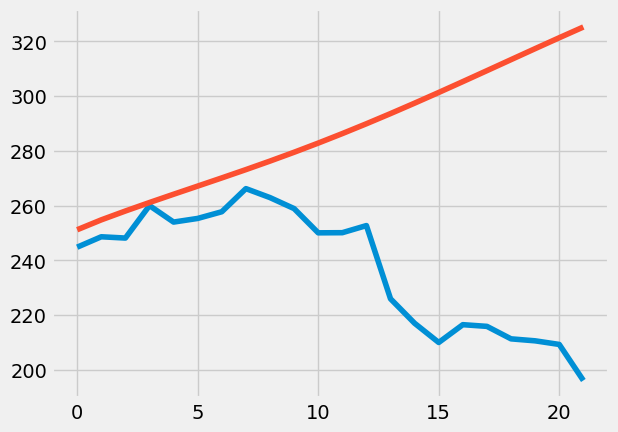

In [ ]:
plt.plot(actual_df[['Open','pred_Open']])

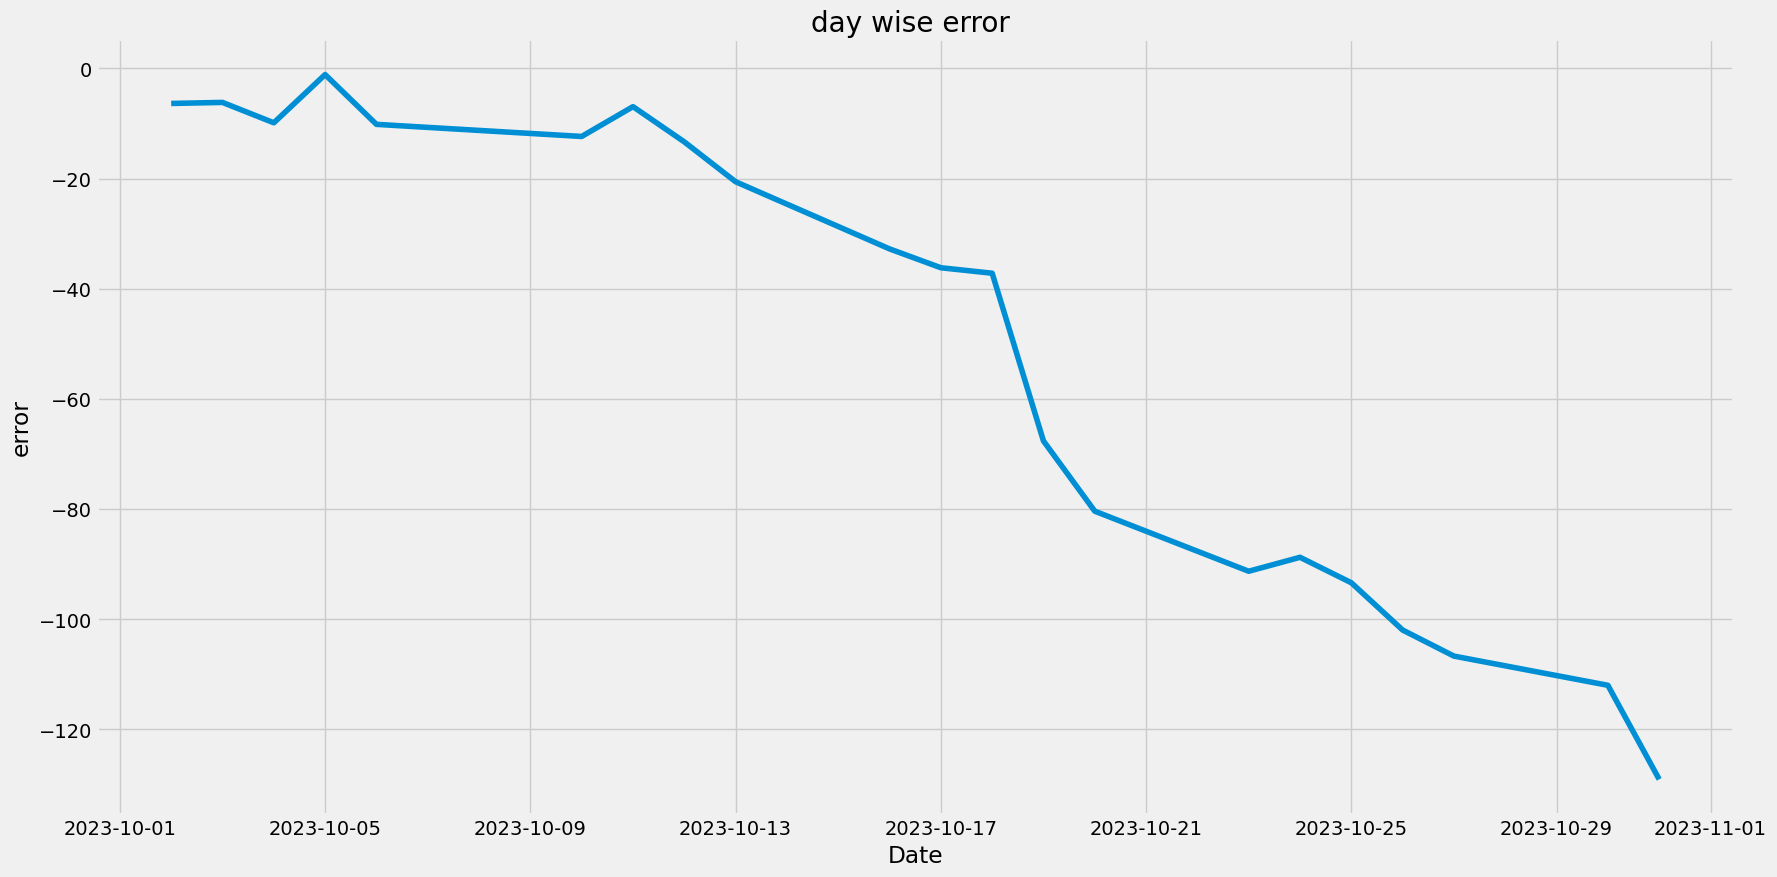

In [ ]:
plt.figure(figsize=(18,9))
plt.plot(actual_df['Error'])
plt.title('day wise error ')
plt.xlabel('Date')
plt.ylabel('error')
plt.tight_layout()
plt.show()